In [3]:
import os
import json
import glob
import copy
import openpyxl
from PIL import Image
import pandas as pd
from pprint import pprint
from PIL import Image, ImageDraw, ImageFont

pd.set_option('display.max_columns', None)

## Step 1. Give the labelme annotated json parent path 
Must contain annotated jsons corresponding to one pdf only

In [58]:
document_path = r"C:\Users\Ragha\Desktop\My_data\Accord\templates\Dl\DL_IRISH\irish_passport_page_0.jpg"
annotation_file_parent_path = os.path.dirname(document_path)
annotation_json_paths = glob.glob(annotation_file_parent_path + "\*.json")
print(len(annotation_json_paths))
annotation_json_paths

1


['C:\\Users\\Ragha\\Desktop\\My_data\\Accord\\templates\\Dl\\DL_IRISH\\irish_passport_page_0.json']

## Step 2. Create the annotation excel file

In [59]:
def create_annotation_excel_file(annotation_json_paths, document_path):

    overwrite = False
    
    excel_fname_to_be_saved_wo_ext = os.path.splitext(document_path)[0].split("\\")[-1]
    annotation_excel_save_path = os.path.join(os.path.dirname(annotation_json_paths[0]), excel_fname_to_be_saved_wo_ext+".xlsx") 
    
    if os.path.isfile(annotation_excel_save_path):
        user_input = input("File already exists. Do you really want to overwrite the excel? Type 'y' or 'n': ")
        overwrite = True if user_input == "y" else False
        
        if overwrite:
            with pd.ExcelWriter(annotation_excel_save_path) as writer:
                for annotation_json_path in annotation_json_paths:
                    annotation_json = json.load(open(annotation_json_path))

                    col_headers = [shape['label'] for shape in annotation_json['shapes'] if "value" in shape['label']]

                    # Specify Required Meta Data column in the excel other than the other column headers
                    req_cols = ["original_image_path", "annotation_json_path", "font_path", "font_size"] + col_headers
                    df = pd.DataFrame(columns = req_cols)

                    original_image_path = annotation_json_path.replace(".json", ".jpg")
                    df.loc[len(df.index)] = [original_image_path, annotation_json_path] + ['']*(len(req_cols)-2)

                    df.to_excel(writer,  sheet_name = "page_" + annotation_json_path.split("\\")[-1].split("page_")[-1].split(".")[0], index=False)

            print("Excel file created at : {}".format(annotation_excel_save_path))     

        else:
            print("Excel file not created !")

    else:
        with pd.ExcelWriter(annotation_excel_save_path) as writer:
            for annotation_json_path in annotation_json_paths:
                annotation_json = json.load(open(annotation_json_path))

                col_headers = [shape['label'] for shape in annotation_json['shapes'] if "value" in shape['label']]

                # Specify Required Meta Data column in the excel other than the other column headers
                req_cols = ["original_image_path", "annotation_json_path", "font_path", "font_size"] + col_headers
                df = pd.DataFrame(columns = req_cols)

                original_image_path = annotation_json_path.replace(".json", ".jpg")
                df.loc[len(df.index)] = [original_image_path, annotation_json_path] + ['']*(len(req_cols)-2)

                df.to_excel(writer,  sheet_name = "page_" + annotation_json_path.split("\\")[-1].split("page_")[-1].split(".")[0], index=False)

        print("Excel file created at : {}".format(annotation_excel_save_path))
 
    return annotation_excel_save_path
    

In [60]:
# annotation_excel_save_path = r"C:\Users\ADMIN\OneDrive - ushur.com\KAUSHAL\Ushur\INTERNSHIP\DISA\AUTO_ANNOTATION\output.xlsx"
annotation_excel_save_path = create_annotation_excel_file(annotation_json_paths, document_path)

File already exists. Do you really want to overwrite the excel? Type 'y' or 'n': N
Excel file not created !


## Step 3. Fill the excel

## Step 4. Auto Fill the samples

In [61]:
def get_col_header_to_col_data_mapping(annotations_df):
    """
    Returns a dictionary mapping column headers to column data from the given DataFrame.

    Args:
        annotations_df (pandas.DataFrame): The DataFrame containing the column headers and data.

    Returns:
    
        dict: A dictionary mapping column headers to column data.
    """
    
    # Convert the DataFrame to a dictionary, with column headers as keys and column data as values
    col_header_to_col_data_mapping = annotations_df.to_dict('list')

    # Convert keys to strings using a dictionary comprehension
    col_header_to_col_data_mapping = {str(i): j for i, j in col_header_to_col_data_mapping.items()}

    return col_header_to_col_data_mapping


def get_col_header_to_coordinates_mapping(col_header_to_col_data_mapping):
    """
    Returns a dictionary mapping column headers to their corresponding coordinates from the given mapping.

    Args:
        col_header_to_col_data_mapping (dict): The mapping of column headers to column data.

    Returns:
        dict: A dictionary mapping column headers to coordinates.
    """
    
    # Extract the path to the annotation JSON file from the mapping
    annotation_json_path = col_header_to_col_data_mapping['annotation_json_path'][0]

    # Load the annotation JSON file
    with open(annotation_json_path, 'r') as f:
        annotations_json = json.load(f)

    col_header_to_coordinates_mapping = {}

    # Iterate over shapes in the annotation JSON
    for shape in annotations_json['shapes']:
        # Check if the shape label is present in the column header mapping
        if shape['label'] in col_header_to_col_data_mapping:
            # Extract the x and y coordinates from the shape
            x1, y1 = map(int, shape['points'][0])
            x2, y2 = map(int, shape['points'][1])
            
            # Add the coordinates to the mapping
            col_header_to_coordinates_mapping[shape['label']] = (x1, y1, x2, y2)
    
    return col_header_to_coordinates_mapping


# 05/10/2023
def overlay_image(image_to_be_filled, image_to_be_overlaid_path, position):
    base_image = image_to_be_filled
    overlay_image = Image.open(image_to_be_overlaid_path)
    
    width = position[2] - position[0]
    height = position[3] - position[1]
    new_size = (width, height)  # Replace width and height with the desired dimensions

    # Resize the image
    overlay_image = overlay_image.resize(new_size)

    # Overlay the images
    base_image.paste(overlay_image, (position[0], position[1]))   


def fill_images(col_header_to_col_data_mapping, col_header_to_coordinates_mapping, num_of_augmented_images_to_be_filled, display_image=False):
    """
    Fills the original image with values from the column data based on the coordinates mapping.

    Args:
        col_header_to_col_data_mapping (dict): The mapping of column headers to column data.
        col_header_to_coordinates_mapping (dict): The mapping of column headers to coordinates.
        num_of_augmented_images_to_be_filled (int): The number of augmented images to generate.
        display_image (bool, optional): Whether to display each filled image. Defaults to False.

    Returns:
        list: A list of augmented images.
    """
    
    # Get the original image path
    original_image_path = col_header_to_col_data_mapping['original_image_path'][0]

    # Open the original image
    original_image = Image.open(original_image_path)

    augmented_images = []

    for i in range(num_of_augmented_images_to_be_filled):
        # Create a copy of the original image
        image_to_be_filled = copy.deepcopy(original_image)
        draw = ImageDraw.Draw(image_to_be_filled)

        # Set the font name and size
        font_path = col_header_to_col_data_mapping['font_path'][i]
        font_size = col_header_to_col_data_mapping['font_size'][i]
        font = ImageFont.truetype(font_path, int(float(font_size)))

        # Fill the values
        for col_header, coordinates in col_header_to_coordinates_mapping.items():
            if 'image' not in col_header:
                value_to_be_filled = col_header_to_col_data_mapping[col_header][i]
                x, y = coordinates[0], coordinates[1]
                # print(col_header, x,y)
                draw.text((x+1, y-5), str(value_to_be_filled), font=font, fill=(0, 0, 0))
                
        for col_header, coordinates in col_header_to_coordinates_mapping.items():
            if 'image' in col_header:
                image_to_be_overlaid_path = col_header_to_col_data_mapping[col_header][i]
                overlay_image(image_to_be_filled, image_to_be_overlaid_path, coordinates)

        augmented_images.append(image_to_be_filled)
        if display_image:
            display(image_to_be_filled)

    return augmented_images

In [62]:
# from PIL import Image
# import openpyxl
# import os

In [63]:
def get_filled_images(annotation_excel_save_path):
    
    wb = openpyxl.load_workbook(annotation_excel_save_path)
    sheet_names = wb.sheetnames
    
    # List of augmented images
    augmented_images = []
    
    for sheet_name in sheet_names:
        print("Processing sheet: {} ...".format(sheet_name))
        
        # Read the excel file
        annotations_df = pd.read_excel(annotation_excel_save_path, sheet_name=sheet_name).fillna("")
        num_of_augmented_images_to_be_filled = annotations_df.shape[0]
        print("Filling {} images ...".format(num_of_augmented_images_to_be_filled))

        # Get column header <=> values mapping
        col_header_to_col_data_mapping = get_col_header_to_col_data_mapping(annotations_df)
        print(col_header_to_col_data_mapping)        

        # Get column header <=> coordinates mapping
        col_header_to_coordinates_mapping = get_col_header_to_coordinates_mapping(col_header_to_col_data_mapping)
        print(col_header_to_coordinates_mapping)
                        
        # Create augmented samples
        augmented_images = fill_images(
            col_header_to_col_data_mapping, 
            col_header_to_coordinates_mapping, 
            num_of_augmented_images_to_be_filled, 
            display_image=True
        )
        
        # Save the augmented images
        output_folder_path = os.path.join(os.path.dirname(annotation_excel_save_path), "AUGMENTED_IMAGES")
        if not os.path.exists(output_folder_path):
            os.mkdir(output_folder_path)
        
        original_image_fname_wo_ext = os.path.splitext(col_header_to_col_data_mapping['original_image_path'][0])[0].split("\\")[-1]
        for aug_idx, augmented_image in enumerate(augmented_images):
            aug_image_save_path = os.path.join(output_folder_path, original_image_fname_wo_ext + "_AUG_" + str(aug_idx) + ".jpg")
            augmented_image.save(aug_image_save_path)
           
            # Crop the augmented image into Front_card and Back_card
            front_card, back_card = crop_image(aug_image_save_path)

            # Save the cropped halves
            front_card.save(os.path.join(output_folder_path, original_image_fname_wo_ext + "_AUG_" + str(aug_idx) + "_Front_card.jpg"))
            back_card.save(os.path.join(output_folder_path, original_image_fname_wo_ext + "_AUG_" + str(aug_idx) + "_Back_card.jpg")) 
            print(front_card)

##split in to half and rm the previous img

In [64]:
# from PIL import Image
# import openpyxl
# import os

# def crop_image(image_path):
#     # Open the image using PIL
#     image = Image.open(image_path)

#     # Get the width and height of the image
#     width, height = image.size

#     # Calculate the split point (halfway through the height)
#     split_point = height // 2

#     # Crop the top half of the image
#     front_card = image.crop((0, 0, width, split_point))

#     # Crop the bottom half of the image
#     back_card = image.crop((0, split_point, width, height))

#     return front_card, back_card

# def get_filled_images(annotation_excel_save_path):
#     wb = openpyxl.load_workbook(annotation_excel_save_path)
#     sheet_names = wb.sheetnames

#     # List of augmented images
#     augmented_images = []

#     for sheet_name in sheet_names:
#         print("Processing sheet: {} ...".format(sheet_name))

#         # Read the excel file
#         annotations_df = pd.read_excel(annotation_excel_save_path, sheet_name=sheet_name).fillna("")
#         num_of_augmented_images_to_be_filled = annotations_df.shape[0]
#         print("Filling {} images ...".format(num_of_augmented_images_to_be_filled))

#         # Get column header <=> values mapping
#         col_header_to_col_data_mapping = get_col_header_to_col_data_mapping(annotations_df)
#         #         print(col_header_to_col_data_mapping)

#         # Get column header <=> coordinates mapping
#         col_header_to_coordinates_mapping = get_col_header_to_coordinates_mapping(col_header_to_col_data_mapping)
#         #         print(col_header_to_coordinates_mapping)

#         # Create augmented samples
#         augmented_images = fill_images(
#             col_header_to_col_data_mapping,
#             col_header_to_coordinates_mapping,
#             num_of_augmented_images_to_be_filled,
#             display_image=True
#         )

#         # Save the augmented images
#         output_folder_path = os.path.join(os.path.dirname(annotation_excel_save_path), "AUGMENTED_IMAGES")
#         if not os.path.exists(output_folder_path):
#             os.mkdir(output_folder_path)

#         original_image_fname_wo_ext = os.path.splitext(col_header_to_col_data_mapping['original_image_path'][0])[0].split("\\")[-1]
#         for aug_idx, augmented_image in enumerate(augmented_images):
#             aug_image_save_path = os.path.join(output_folder_path, original_image_fname_wo_ext + "_AUG_" + str(aug_idx) + ".jpg")
#             augmented_image.save(aug_image_save_path)

#             # Crop the augmented image into Front_card and Back_card
#             front_card, back_card = crop_image(aug_image_save_path)

#             # Save the cropped halves
#             front_card.save(os.path.join(output_folder_path, original_image_fname_wo_ext + "_AUG_" + str(aug_idx) + "_Front_card.jpg"))
#             back_card.save(os.path.join(output_folder_path, original_image_fname_wo_ext + "_AUG_" + str(aug_idx) + "_Back_card.jpg"))
#             # Remove the original image
#             os.remove(aug_image_save_path)

In [71]:
from PIL import Image
import openpyxl
import os

#def crop_image(image_path, top_crop_width, top_crop_height, top_crop_right, top_crop_left, bottom_crop_width, bottom_crop_height,bottom_crop_right, bottom_crop_left):
def crop_image(image_path, top_crop_width, top_crop_height, bottom_crop_width, bottom_crop_height):
    # Open the image using PIL
    image = Image.open(image_path)

    # Calculate the coordinates for cropping the top part
    top_left = 0
    top_top = 0
    top_right = top_crop_width
    top_bottom = top_crop_height

    # Crop the top part of the image
    top_part = image.crop((top_left, top_top, top_right, top_bottom))

    # Calculate the coordinates for cropping the bottom part
    bottom_left = 1
    bottom_top = image.height - bottom_crop_height
    bottom_right = bottom_crop_width
    bottom_bottom = image.height

    # Crop the bottom part of the image
    bottom_part = image.crop((bottom_left, bottom_top, bottom_right, bottom_bottom))

    return top_part, bottom_part

    
def get_front_and_back_face_cropped(image_path, front_face_coordinates, back_face_coordinates):
    
    image = Image.open(image_path)
    front_face_image = image.crop(front_face_coordinates)
    back_face_image = image.crop(back_face_coordinates)
    
    return front_face_image, back_face_image
    
    

def get_filled_images(annotation_excel_save_path):
    wb = openpyxl.load_workbook(annotation_excel_save_path)
    sheet_names = wb.sheetnames

    # List of augmented images
    augmented_images = []

    for sheet_name in sheet_names:
        print("Processing sheet: {} ...".format(sheet_name))

        # Read the excel file
        annotations_df = pd.read_excel(annotation_excel_save_path, sheet_name=sheet_name).fillna("")
        num_of_augmented_images_to_be_filled = annotations_df.shape[0]
        print("Filling {} images ...".format(num_of_augmented_images_to_be_filled))

        # Get column header <=> values mapping
        col_header_to_col_data_mapping = get_col_header_to_col_data_mapping(annotations_df)
        print(col_header_to_col_data_mapping)

        # Get column header <=> coordinates mapping
        col_header_to_coordinates_mapping = get_col_header_to_coordinates_mapping(col_header_to_col_data_mapping)
        print(col_header_to_coordinates_mapping)

        # Create augmented samples
        augmented_images = fill_images(
            col_header_to_col_data_mapping,
            col_header_to_coordinates_mapping,
            num_of_augmented_images_to_be_filled,
            display_image=True
        )

        # Save the augmented images
        output_folder_path = os.path.join(os.path.dirname(annotation_excel_save_path), "AUGMENTED_IMAGES")
        if not os.path.exists(output_folder_path):
            os.mkdir(output_folder_path)

        original_image_fname_wo_ext = os.path.splitext(col_header_to_col_data_mapping['original_image_path'][0])[0].split("\\")[-1]
        for aug_idx, augmented_image in enumerate(augmented_images):
            aug_image_save_path = os.path.join(output_folder_path, original_image_fname_wo_ext + "_AUG_" + str(aug_idx) + ".jpg")
            augmented_image.save(aug_image_save_path)

#             # Specify the desired width and height for cropping the top and bottom parts
#             top_crop_width = 1500
#             top_crop_height = 1000
#             bottom_crop_width = 1400
#             bottom_crop_height = 1200

#             # Crop the augmented image based on the specified dimensions
#             top_part, bottom_part = crop_image(aug_image_save_path, top_crop_width, top_crop_height, bottom_crop_width, bottom_crop_height)
            
            front_face_top = 1
            front_face_left = 1
            front_face_bottom = 401
            front_face_right = 638
    
            back_face_top = 850
            back_face_left = 1
            back_face_bottom = 1706
            back_face_right = 6
            
            front_face_coordinates, back_face_coordinates = [front_face_left,front_face_top, front_face_right,front_face_bottom], [back_face_left,back_face_top,back_face_right ,back_face_bottom ]
            front_face_image, back_face_image = get_front_and_back_face_cropped(aug_image_save_path, front_face_coordinates, back_face_coordinates)

            # Save the cropped halves
            front_face_image.save(os.path.join(output_folder_path, original_image_fname_wo_ext + "_AUG_" + str(aug_idx) + "front.jpg"))
            back_face_image.save(os.path.join(output_folder_path, original_image_fname_wo_ext + "_AUG_" + str(aug_idx) + "_Bottom.jpg"))
            
            # Remove the original image
            os.remove(aug_image_save_path)
            

Processing sheet: page_0 ...
Filling 2 images ...
{'original_image_path': ['C:\\Users\\Ragha\\Desktop\\My_data\\Accord\\templates\\Dl\\DL_IRISH\\irish_passport_page_0.jpg', 'C:\\Users\\Ragha\\Desktop\\My_data\\Accord\\templates\\Dl\\DL_IRISH\\irish_passport_page_0.jpg'], 'annotation_json_path': ['C:\\Users\\Ragha\\Desktop\\My_data\\Accord\\templates\\Dl\\DL_IRISH\\irish_passport_page_0.json', 'C:\\Users\\Ragha\\Desktop\\My_data\\Accord\\templates\\Dl\\DL_IRISH\\irish_passport_page_0.json'], 'font_path': ['C:\\Users\\Ragha\\Desktop\\My_data\\Accord\\templates\\Dl\\Roboto_Slab\\RobotoSlab-VariableFont_wght.ttf', 'C:\\Users\\Ragha\\Desktop\\My_data\\Accord\\templates\\Dl\\Roboto_Slab\\RobotoSlab-VariableFont_wght.ttf'], 'font_size': [18, 18], 'value_name': [' MARTIN', ' ANDERSON'], 'value_last_name': ['JAMES', 'KYLE'], 'value_issue_place_dob': ['29.09.1999', '28.08.1996'], 'value_issuedate': ['23.12.2023', '24.08.2022'], 'value_issue_exp_date': ['23.12.2033', '24.08.2032'], 'value_id': [8

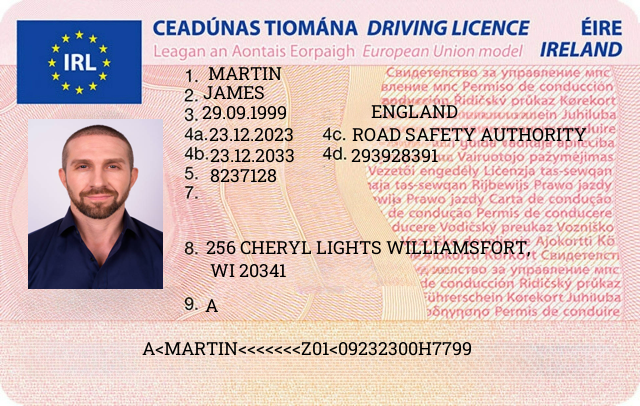

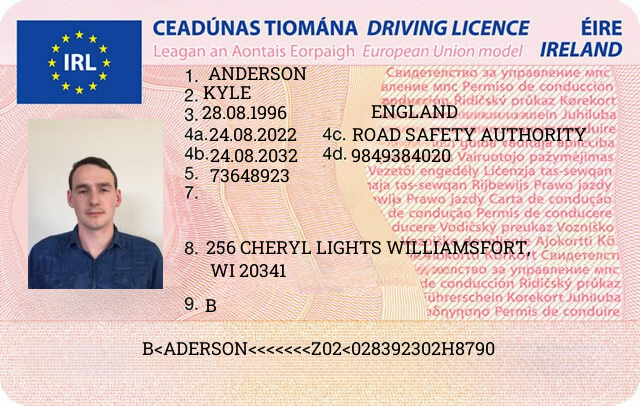

In [72]:
# Call the image augmenter function
# print("Reading excel file : {} ...".format(annotation_excel_save_path))
get_filled_images(annotation_excel_save_path)

# Image Overlay

# Old Code

In [ ]:
# def fill_images(col_header_to_col_data_mapping, col_header_to_coordinates_mapping, num_of_augmented_images_to_be_filled, display_image=False):
    
#     # Get original image path
#     original_image_path = col_header_to_col_data_mapping['original_image_path'][0]
#     original_image = Image.open(original_image_path)
    
#     augmented_images = []
    
#     for i in range(0, num_of_augmented_images_to_be_filled):

#         # Create a copy of the original image
#         image_to_be_filled = copy.deepcopy(original_image)
#         draw = ImageDraw.Draw(image_to_be_filled)

#         # Set the font name and size
#         font_path = col_header_to_col_data_mapping['font_path'][i]
#         font_size = col_header_to_col_data_mapping['font_size'][i]
#         font = ImageFont.truetype(font_path, int(float(font_size)))

#         # Fill the value
#         for col_header in col_header_to_coordinates_mapping:
#             value_to_be_filled = col_header_to_col_data_mapping[col_header][i]
#             x, y = col_header_to_coordinates_mapping[col_header][0], col_header_to_coordinates_mapping[col_header][1]
#             draw.text((x+10, y+5), str(value_to_be_filled), font=font, fill =(0, 0, 0))

#         augmented_images.append(image_to_be_filled)
#         if display_image: display(image_to_be_filled)
        
#     return augmented_images


In [ ]:
# import cv2

# # Load the image
# image = cv2.imread('Passport - Irish_Sample_2.jpg')

# # Check if the image was loaded successfully
# if image is None:
#     print("Error: Unable to load the image.")
# else:
#     # Find the dimensions of the image
#     height, width, _ = image.shape

#     # Define the coordinates of the corners
#     top_left = (0, 0)
#     top_right = (width, 0)
#     bottom_left = (0, height)
#     bottom_right = (width, height)

#     # Print the coordinates
#     print(f'Top-Left: {top_left}')
#     print(f'Top-Right: {top_right}')
#     print(f'Bottom-Left: {bottom_left}')
#     print(f'Bottom-Right: {bottom_right}')

#     # Display the image with corner points marked
#     cv2.circle(image, top_left, 5, (0, 0, 255), -1)
#     cv2.circle(image, top_right, 5, (0, 0, 255), -1)
#     cv2.circle(image, bottom_left, 5, (0, 0, 255), -1)
#     cv2.circle(image, bottom_right, 5, (0, 0, 255), -1)

#     # Display the image with marked corners
#     cv2.imshow('Image with Corners', image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()


In [ ]:
John and Mary Johnson have a valuable collection of vintage watches, worth $15,000.
They decide to add a Scheduled Personal Property Endorsement to their homeowners 
insurance policy to specifically cover these watches. In the event of theft or damage,
they are now covered up to the scheduled value of $15,000.